# GPU Check

In [ ]:
import GPUtil
GPUs = GPUtil.getGPUs()
for gpu in GPUs:
  print(gpu.name, gpu.memoryTotal)

# Imports

In [ ]:
from search_eval.eval_generic import SGLDES
from search_eval.optimizer.SingleImageDataset import SingleImageDataset
from search_eval.utils.common_utils import *
# from search_space.search_space import SearchSpace
from search_space.search_space_nodes import SearchSpace
from search_space.node_space import NodeSpace
from search_space.simple_space import SimpleSpace

from nni import trace
import nni.retiarii.strategy as strategy
import nni.retiarii.serializer as serializer

from nni.retiarii.experiment.pytorch import RetiariiExperiment, RetiariiExeConfig
from nni.retiarii.evaluator.pytorch import Lightning, Trainer
from nni.retiarii.evaluator.pytorch.lightning import DataLoader

import torch

torch.cuda.empty_cache()
dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
print('CUDA available: {}'.format(torch.cuda.is_available()))

# Search == One-Shot
# SGLD == True

In [ ]:

total_iterations = 3500

resolution = 64
noise_type = 'gaussian'
noise_level = '0.09'
phantom =       np.load(f'/home/joe/nas-for-dip/phantoms/ground_truth/{resolution}/{45}.npy')
phantom_noisy = np.load(f'/home/joe/nas-for-dip/phantoms/{noise_type}/res_{resolution}/nl_{noise_level}/p_{45}.npy')

learning_rate = 0.01
buffer_size = 100
patience = 1000
weight_decay = 5e-4
show_every = 500
report_every = 100

# Create the lightning module
module = SGLDES(
                phantom=phantom, 
                phantom_noisy=phantom_noisy,
                
                learning_rate=learning_rate, # consider .01
                buffer_size=buffer_size,
                patience=patience,
                weight_decay= weight_decay,

                show_every=show_every,
                report_every=report_every,
                HPO=False,
                NAS=True,
                OneShot=True,
                SGLD_regularize=True,
                switch=None
                )

# Create a PyTorch Lightning trainer
trainer = Trainer(
            max_epochs=total_iterations,
            fast_dev_run=False,
            gpus=1,
            )
            
if not hasattr(trainer, 'optimizer_frequencies'):
    trainer.optimizer_frequencies = []


# Create the lighting object for evaluator
train_loader = DataLoader(SingleImageDataset(phantom, num_iter=1), batch_size=1)
val_loader = DataLoader(SingleImageDataset(phantom, num_iter=1), batch_size=1)

lightning = Lightning(lightning_module=module, trainer=trainer, train_dataloaders=train_loader, val_dataloaders=val_loader)


# Select the Search Strategy
search_strategy = strategy.DARTS()
# search_strategy = strategy.DartsStrategy()
# search_strategy = strategy.ENAS()
# search_strategy = strategy.GumbelDARTS()
# search_strategy = strategy.RandomOneShot()

# # Create a Search Space
# model_space = SearchSpace(depth=4, enNodes=2)
depth = 4
nodes_per_layer = 1
ops_per_node = 1
poolOps_per_node = 1
upsampleOps_per_node = 1

model_space = NodeSpace(
         depth=depth, 
         nodes_per_layer=nodes_per_layer,
         ops_per_node=ops_per_node, 
         poolOps_per_node=poolOps_per_node, 
         upsampleOps_per_node=upsampleOps_per_node
        )

# fast_dev_run=False

config = RetiariiExeConfig(execution_engine='oneshot')
experiment = RetiariiExperiment(model_space, evaluator=lightning, strategy=search_strategy)
experiment.run(config)

In [ ]:
experiment.export_top_models()[0]

In [ ]:
# retrain top model
from search_space.node_space import exportedModel
from search_space.unet import exportedUNet
from search_eval.eval_no_search_SGLD_ES import Eval_SGLD_ES

# construct output and retrain
exported_arch = experiment.export_top_models()[0]
# extract value from key -- pool 0
print("--------------------")
print("--------------------")
for i in range(depth):
    print(f'pool {i+1}: ', exported_arch[f'pool {i}/op_1_0'])
    print(f'encoder {i+1}: ', exported_arch[f'encoder {i}/op_1_0'])
    print("--------------------")
for i in range(depth):
    print(f'upsample {i+1}: ', exported_arch[f'upsample {i}/op_1_0'])
    print(f'decoder {i+1}: ', exported_arch[f'decoder {i}/op_1_0'])
    print("--------------------")
print("--------------------\n\n\n")

model = exportedModel(1,1,depth,exported_arch)

learning_rate = 0.01
buffer_size = 100
patience = 1500
weight_decay = 5e-7
show_every = 500
report_every = 50

print(f"\n\n----------------------------------")
print(f'Experiment Configuration:')
print(f'\tTotal Iterations: {total_iterations}')

print(f'\tPatience: {patience}')
print(f'\tBuffer Size: {buffer_size}')
print(f'\tLearning Rate: {learning_rate}')
print(f'\tWeight Decay: {weight_decay}')

print(f'\tImage Resolution: {resolution}')
print(f'\tPlotting every {show_every} iterations')
print(f"----------------------------------\n\n")

# Create the lightning module
module = Eval_SGLD_ES(
                phantom=phantom, 
                phantom_noisy=phantom_noisy,

                learning_rate=learning_rate, 
                buffer_size=buffer_size,
                patience=patience,
                weight_decay=weight_decay,
                
                report_every=report_every,
                show_every=show_every,
                model=model,
                )

# Create a PyTorch Lightning trainer
trainer = Trainer(
            max_epochs=total_iterations,
            fast_dev_run=False,
            gpus=1,
            )
            
if not hasattr(trainer, 'optimizer_frequencies'):
    trainer.optimizer_frequencies = []

# Create the lighting object for evaluator
train_loader = DataLoader(SingleImageDataset(phantom, num_iter=1), batch_size=1)

lightning = Lightning(lightning_module=module, trainer=trainer, train_dataloaders=train_loader, val_dataloaders=None)
lightning.fit(model)

In [ ]:
# stop experiment and clear cache
experiment.stop()
torch.cuda.empty_cache()

# testing

CUDA available: True


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs




----------------------------------
Experiment Configuration:
	Total Iterations: 1400
	Burnin Iterations: 200
	Learning Rate: 0.1
	Image Resolution: 64
	Plotting every 50 iterations
----------------------------------


[2023-09-11 06:37:54] WARNING: Validation dataloaders are missing.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params
--------------------------------------
0 | model_cls | UNet    | 31.0 M
1 | criteria  | MSELoss | 0     
--------------------------------------
31.0 M    Trainable params
0         Non-trainable params
31.0 M    Total params
124.146   Total estimated model params size (MB)
/home/joe/.cache/pypoetry/virtualenvs/nas-test-OHy8kATa-py3.8/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/joe/.cache/pypoetry/virtualenvs/nas-test-OHy8kATa-py3.8/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1927: PossibleUserWarning: The number of training batches (1) is smaller than the l

Training: 0it [00:00, ?it/s]

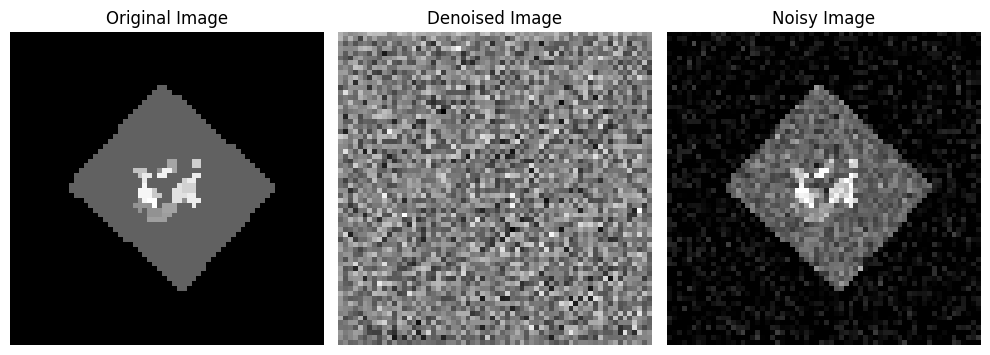

[2023-09-11 06:37:58] Intermediate result: {"iteration": 0, "loss": 0.17105, "psnr_noisy": 7.66886, "psnr_gt": 7.13802}  (Index 0)


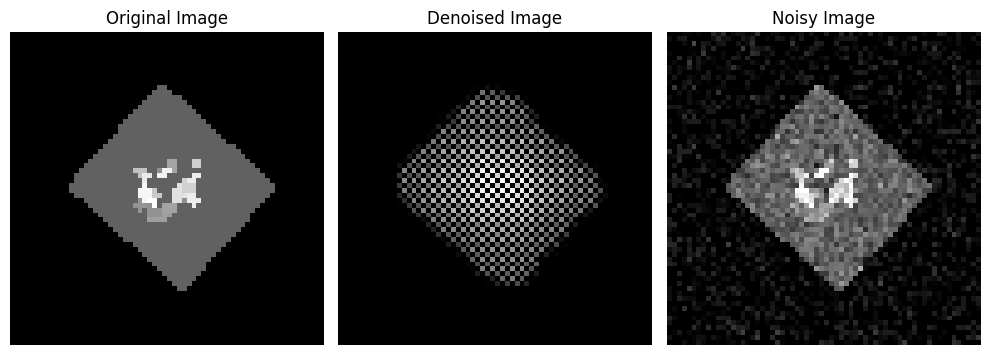

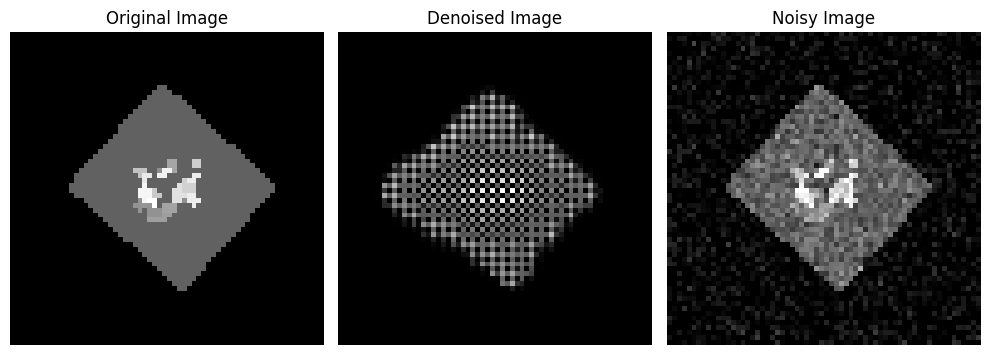

[2023-09-11 06:41:09] Intermediate result: {"iteration": 100, "loss": 0.02513, "psnr_noisy": 15.99893, "psnr_gt": 16.78578}  (Index 1)


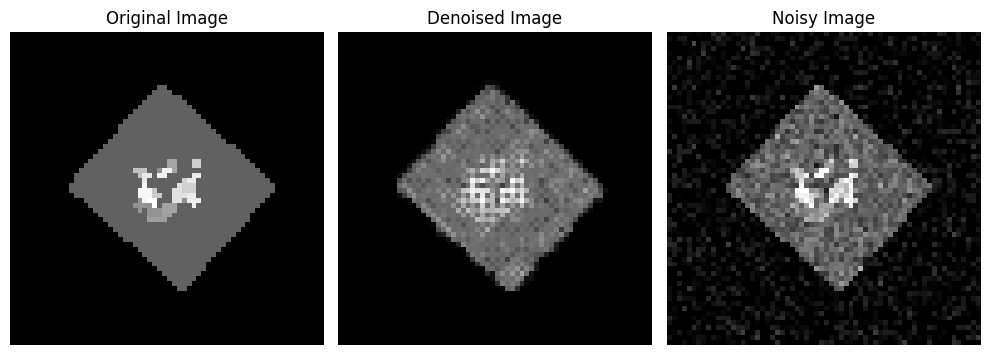

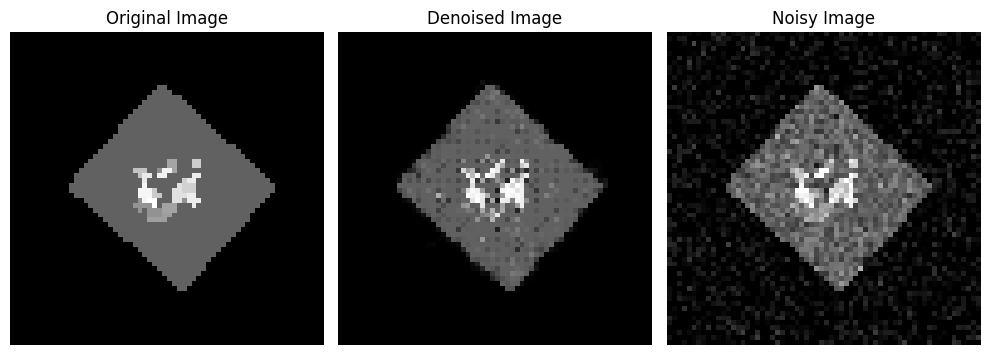

[2023-09-11 06:44:17] Intermediate result: {"iteration": 200, "loss": 0.00518, "psnr_noisy": 22.85498, "psnr_gt": 28.87449}  (Index 2)
MCMC sample count: 0


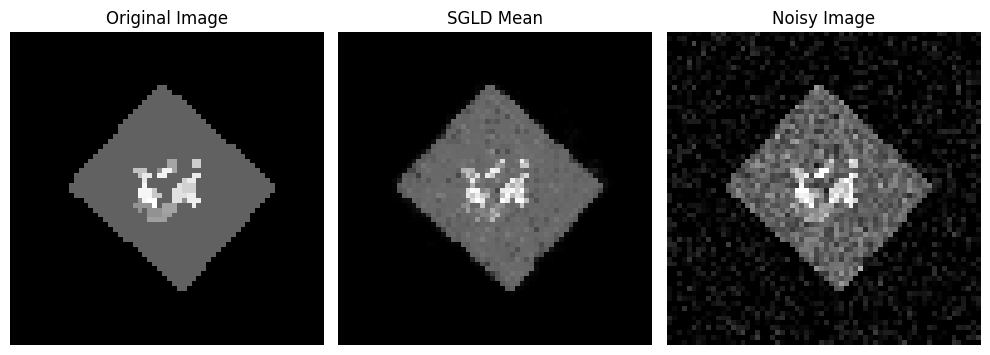

MCMC sample count: 1.0


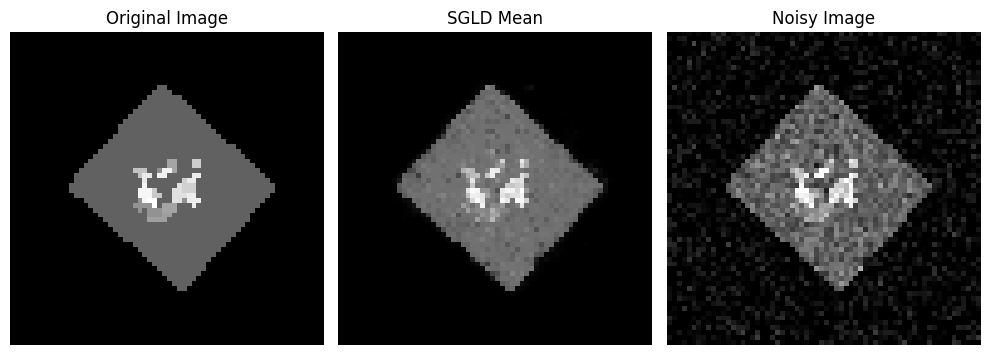

[2023-09-11 06:47:25] Intermediate result: {"iteration": 300, "loss": 0.0049, "sample count": 100, "psnr_sgld_last": 31.48374, "psnr_gt": 28.86964}  (Index 3)
MCMC sample count: 2.0


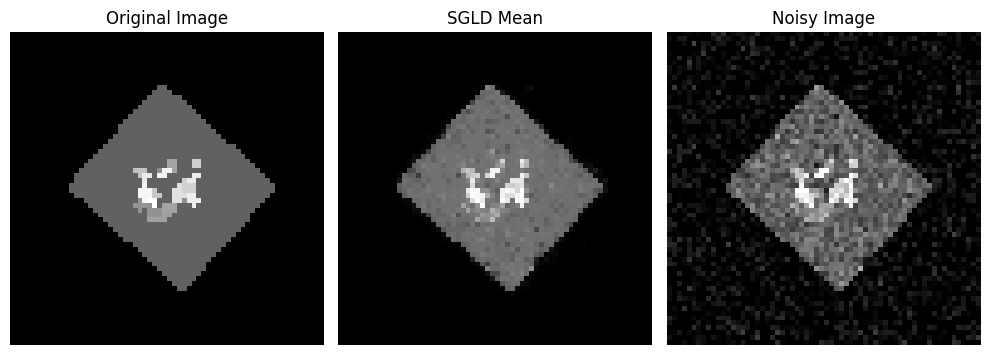

MCMC sample count: 3.0


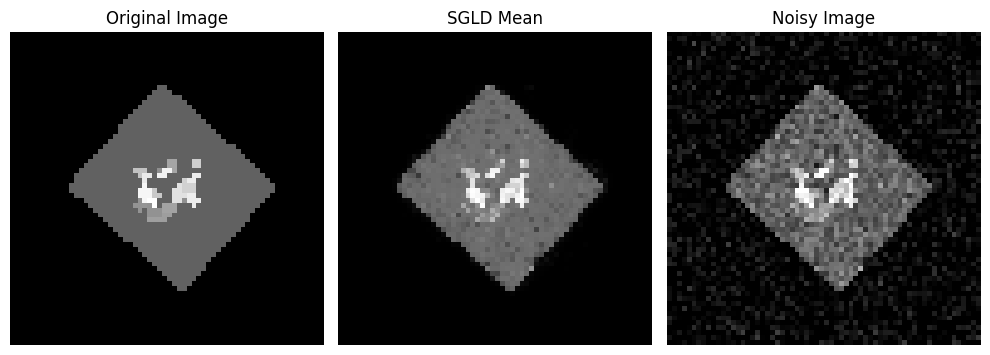

[2023-09-11 06:50:34] Intermediate result: {"iteration": 400, "loss": 0.0045, "sample count": 200, "psnr_sgld_last": 32.27307, "psnr_gt": 29.09819}  (Index 4)
MCMC sample count: 4.0


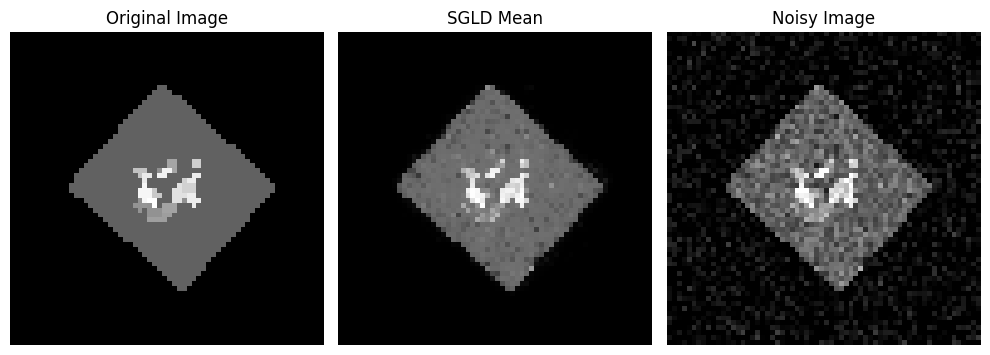

MCMC sample count: 5.0


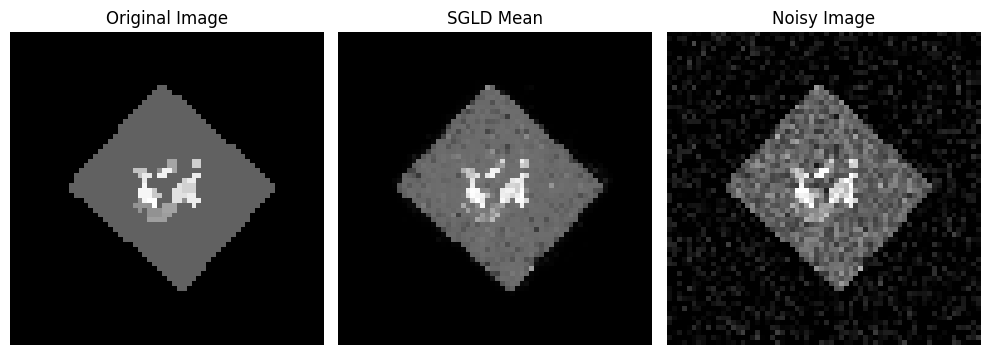

[2023-09-11 06:53:38] Intermediate result: {"iteration": 500, "loss": 0.00429, "sample count": 300, "psnr_sgld_last": 32.33975, "psnr_gt": 29.40034}  (Index 5)
MCMC sample count: 6.0


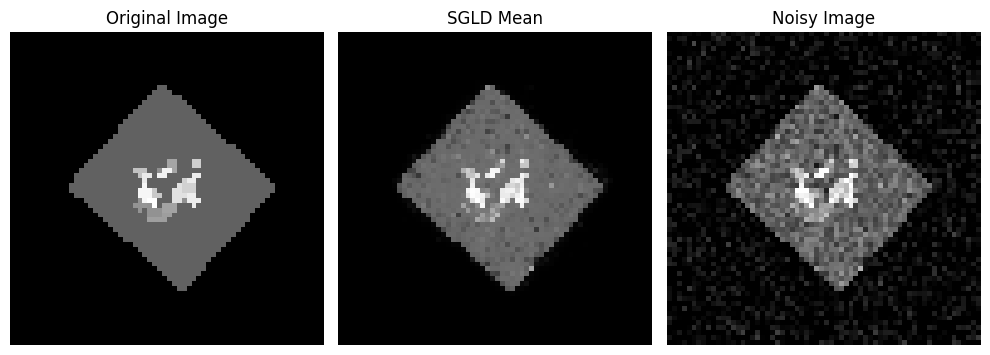

MCMC sample count: 7.0


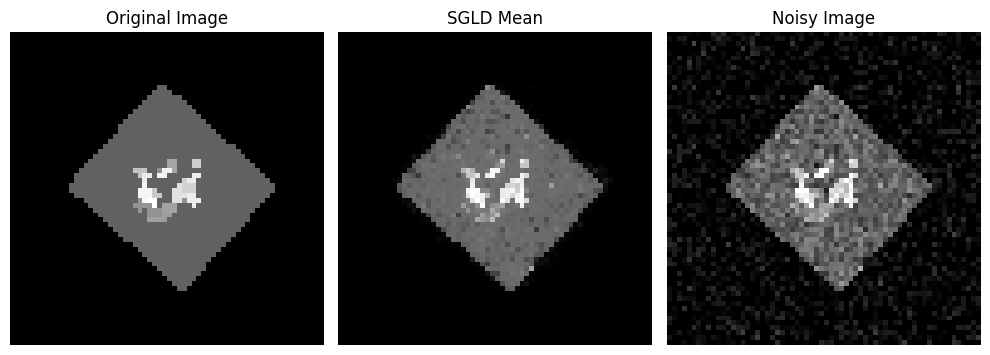

[2023-09-11 06:56:49] Intermediate result: {"iteration": 600, "loss": 0.00415, "sample count": 400, "psnr_sgld_last": 32.31887, "psnr_gt": 28.15599}  (Index 6)
MCMC sample count: 8.0


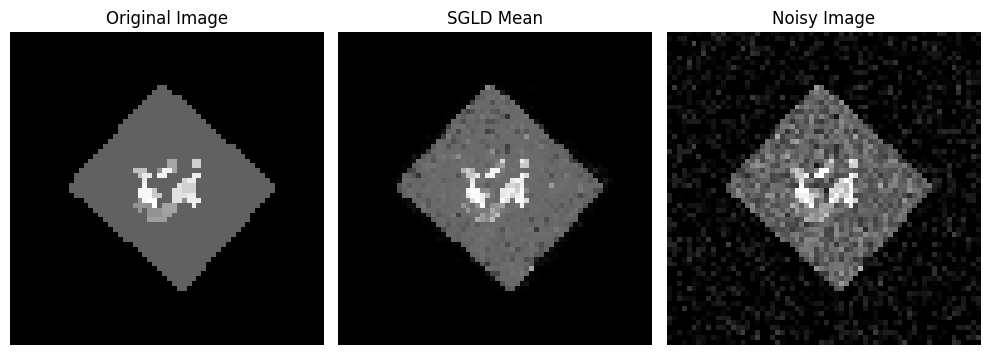

MCMC sample count: 9.0


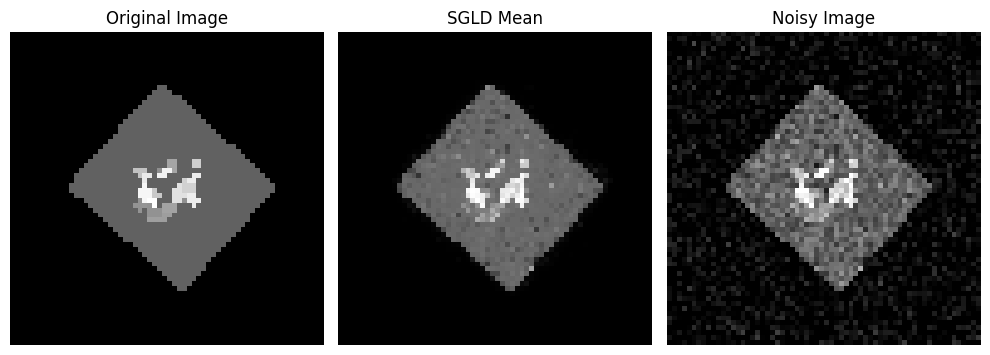

[2023-09-11 06:59:58] Intermediate result: {"iteration": 700, "loss": 0.00454, "sample count": 500, "psnr_sgld_last": 32.66243, "psnr_gt": 29.14177}  (Index 7)
MCMC sample count: 10.0


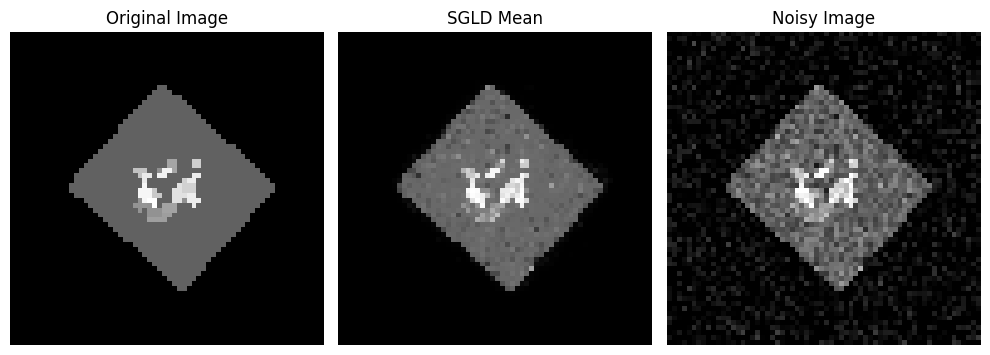

MCMC sample count: 11.0


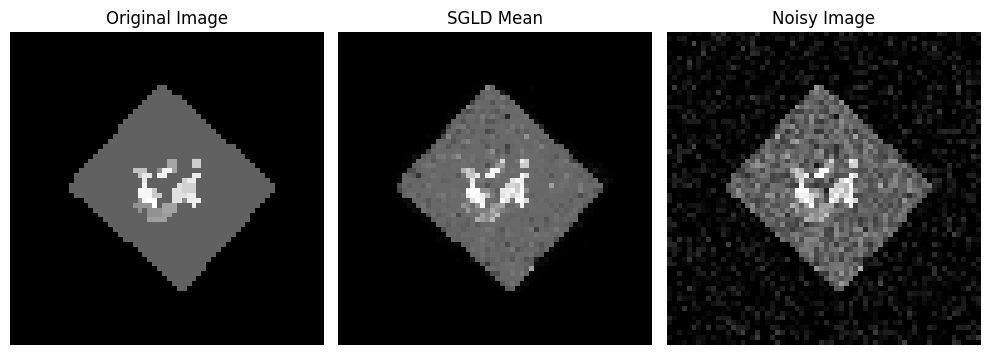

[2023-09-11 07:03:08] Intermediate result: {"iteration": 800, "loss": 0.00432, "sample count": 600, "psnr_sgld_last": 32.97278, "psnr_gt": 30.65185}  (Index 8)
MCMC sample count: 12.0


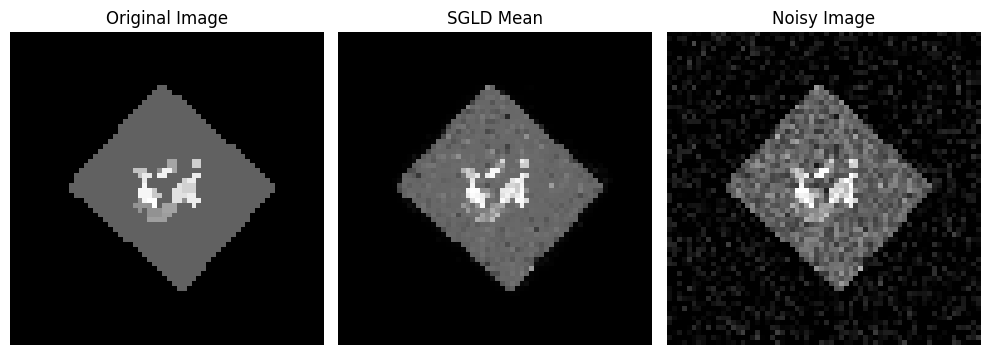

MCMC sample count: 13.0


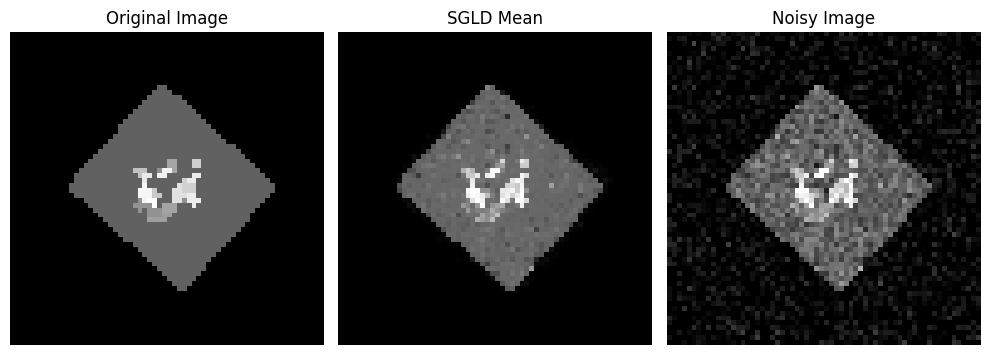

[2023-09-11 07:06:25] Intermediate result: {"iteration": 900, "loss": 0.00438, "sample count": 700, "psnr_sgld_last": 33.41657, "psnr_gt": 29.21015}  (Index 9)
MCMC sample count: 14.0


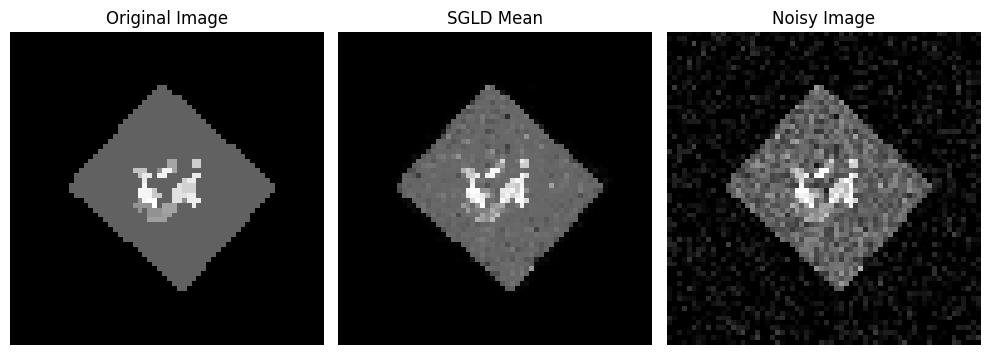

MCMC sample count: 15.0


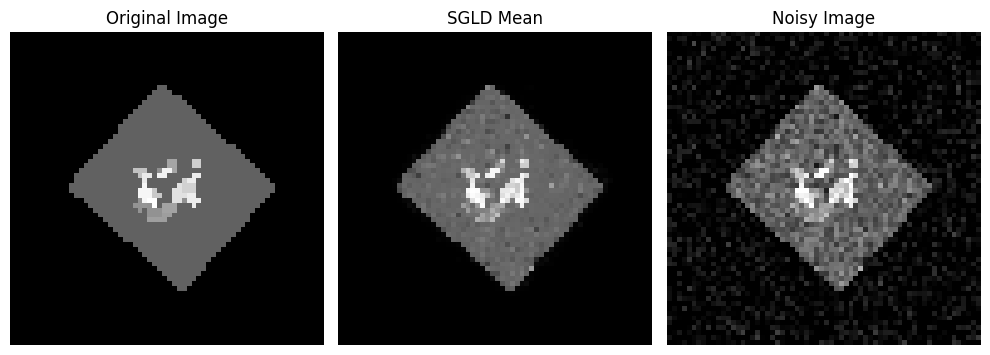

[2023-09-11 07:09:41] Intermediate result: {"iteration": 1000, "loss": 0.00424, "sample count": 800, "psnr_sgld_last": 33.46306, "psnr_gt": 30.30654}  (Index 10)
MCMC sample count: 16.0


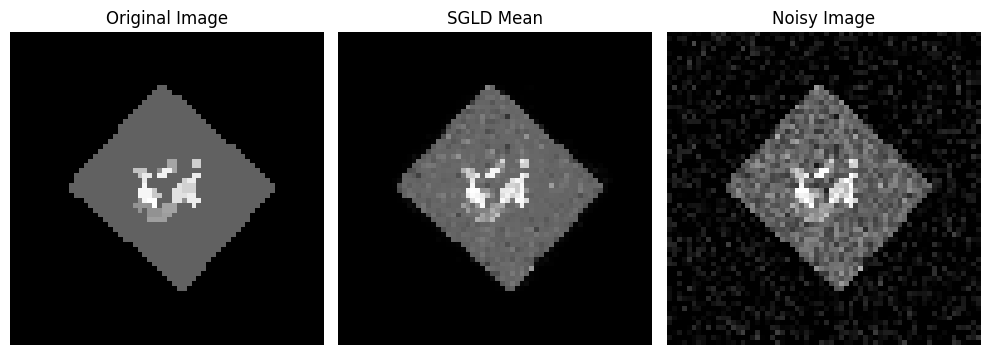

MCMC sample count: 17.0


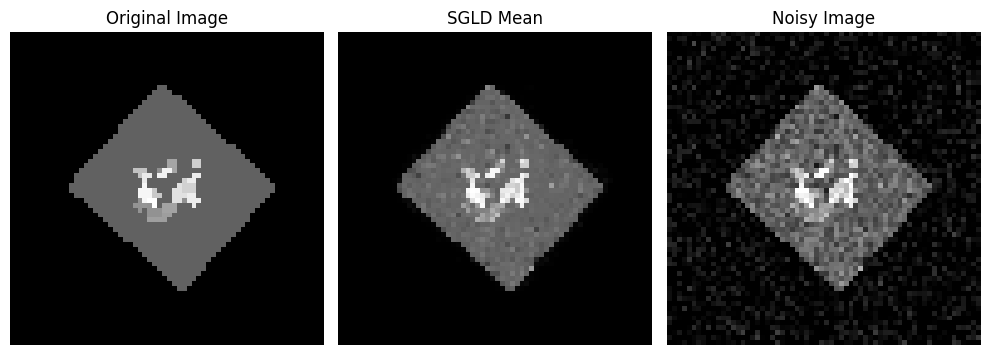

[2023-09-11 07:12:57] Intermediate result: {"iteration": 1100, "loss": 0.00455, "sample count": 900, "psnr_sgld_last": 33.36232, "psnr_gt": 28.32344}  (Index 11)
MCMC sample count: 18.0


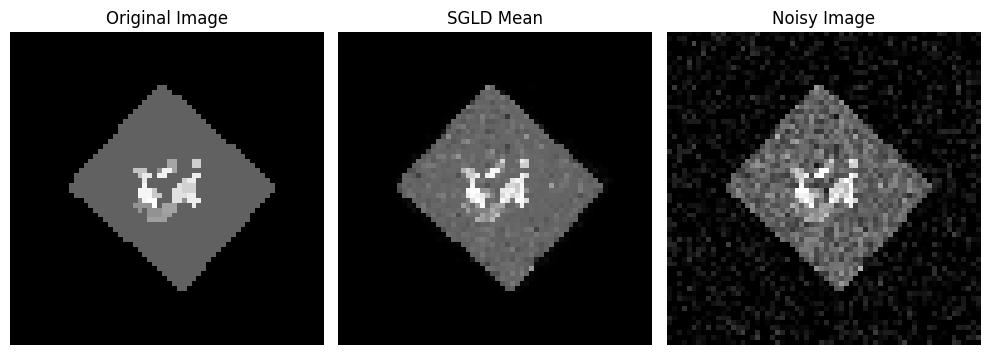

MCMC sample count: 19.0


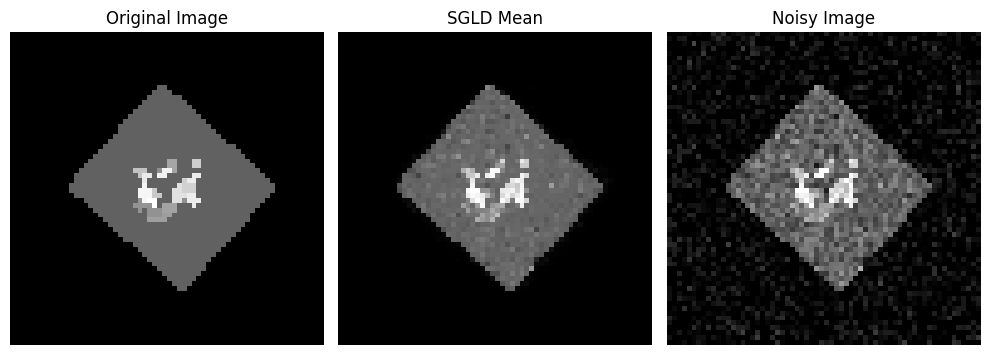

[2023-09-11 07:16:10] Intermediate result: {"iteration": 1200, "loss": 0.00519, "sample count": 1000, "psnr_sgld_last": 33.45377, "psnr_gt": 30.24538}  (Index 12)
MCMC sample count: 20.0


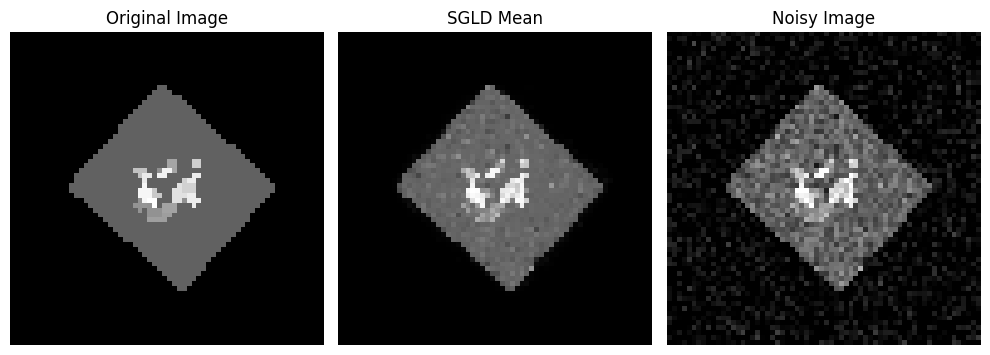

MCMC sample count: 21.0


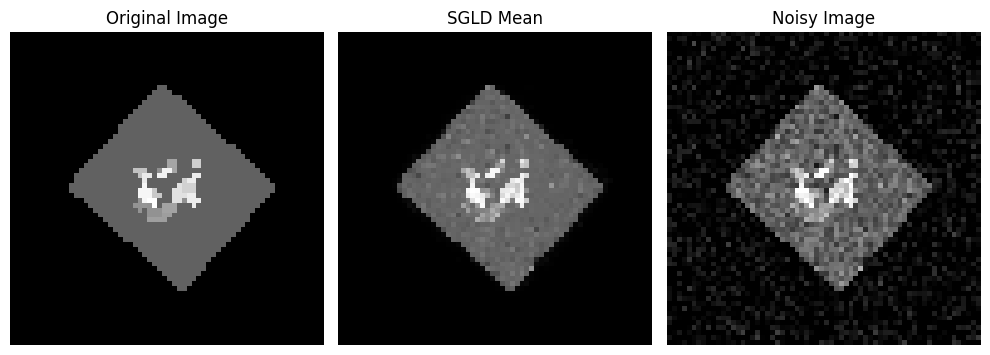

[2023-09-11 07:19:20] Intermediate result: {"iteration": 1300, "loss": 0.00514, "sample count": 1100, "psnr_sgld_last": 33.68042, "psnr_gt": 30.50344}  (Index 13)
MCMC sample count: 22.0


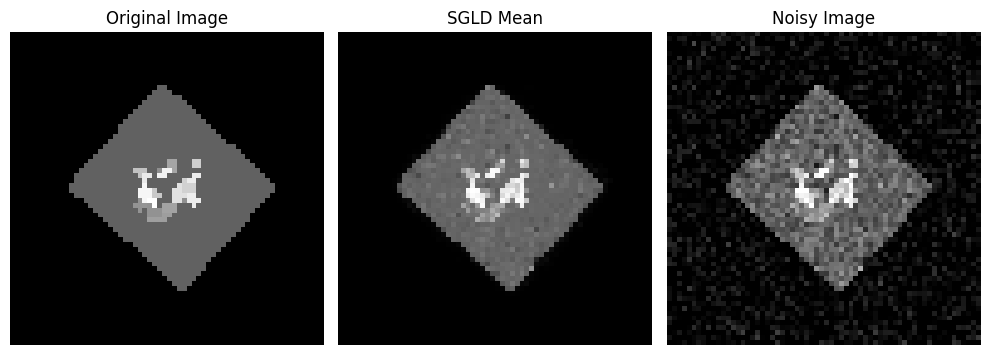

MCMC sample count: 23.0


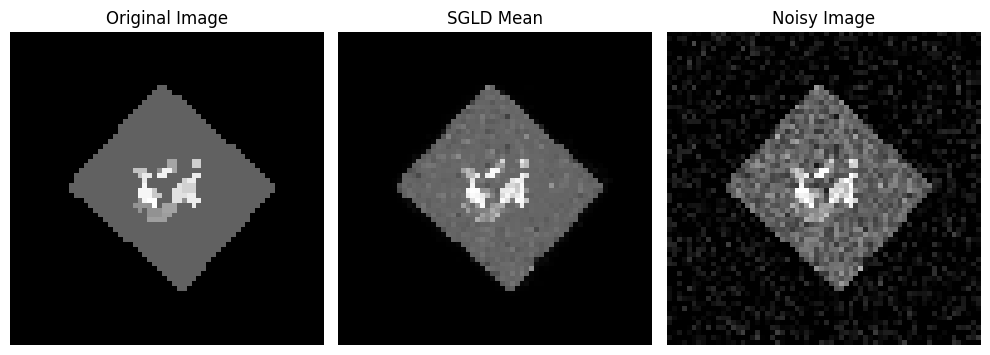

[2023-09-11 07:22:30] Final result: {"loss": 0.004980745259672403}
MCMC sample count: 23.0


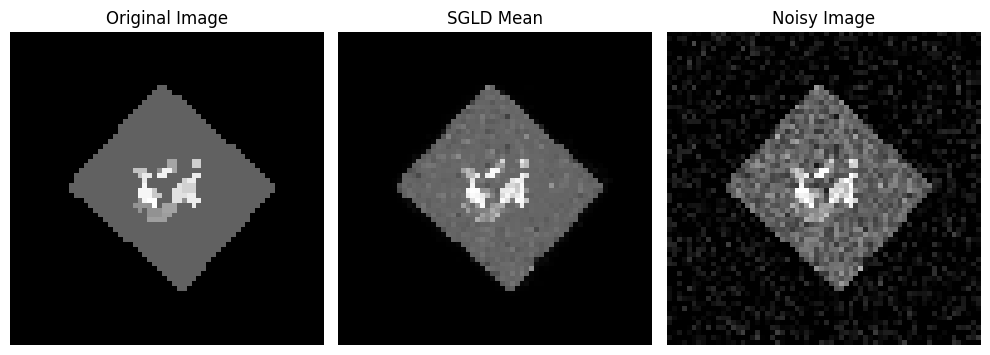

Final SGLD mean PSNR: 33.46034072234372


In [2]:
from search_eval.utils.common_utils import *
from search_eval.eval_no_search_SGLD import Eval_SGLD, SingleImageDataset

from nni.retiarii.evaluator.pytorch import Lightning, Trainer
from nni.retiarii.evaluator.pytorch.lightning import DataLoader
from search_space.unet.unet import UNet

import numpy as np
import torch
torch.cuda.empty_cache()

dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
print('CUDA available: {}'.format(torch.cuda.is_available()))

# INPUTS
total_iterations = 1400
burnin_iter = 200
show_every = 50
lr = 0.1 #  note a smaller learning rate affecs the SGLD, so overfitting happens FASTER at LOWER learning rates (start with 0.01)

model = UNet(in_channels=1, out_channels=1, init_features=64, depth=4)
# model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', in_channels=1, out_channels=1, init_features=64, pretrained=False)

img_id = np.random.randint(0, 50)
resolution = 64
noise_type = 'gaussian'
noise_level = '0.09'
phantom =       np.load(f'/home/joe/nas-for-dip/phantoms/ground_truth/{resolution}/{img_id}.npy')
phantom_noisy = np.load(f'/home/joe/nas-for-dip/phantoms/{noise_type}/res_{resolution}/nl_{noise_level}/p_{img_id}.npy')

print(f"\n\n----------------------------------")
print(f'Experiment Configuration:')
print(f'\tTotal Iterations: {total_iterations}')
print(f'\tBurnin Iterations: {burnin_iter}')
print(f'\tLearning Rate: {lr}')
print(f'\tImage Resolution: {resolution}')

print(f'\tPlotting every {show_every} iterations')
print(f"----------------------------------\n\n")

# Create the lightning module
module = Eval_SGLD(
                phantom=phantom, 
                phantom_noisy=phantom_noisy,
                lr=lr, 
                burnin_iter=burnin_iter,
                model=model, # model defaults to U-net 
                show_every=show_every
                )

# Create a PyTorch Lightning trainer
trainer = Trainer(
            max_epochs=total_iterations,
            fast_dev_run=False,
            gpus=1,
            )
            
if not hasattr(trainer, 'optimizer_frequencies'):
    trainer.optimizer_frequencies = []


# Create the lighting object for evaluator
train_loader = DataLoader(SingleImageDataset(phantom, num_iter=1), batch_size=1)

lightning = Lightning(lightning_module=module, trainer=trainer, train_dataloaders=train_loader, val_dataloaders=None)
lightning.fit(model)